# Introduction

Despite its huge potential advantages, the most significant roadblock to quantum computing is quantum errors. Quantum processes, e.g. gates and measurements, and quantum states are inherently imperfect and fragile as compared to that of their classical counterpart.

Fortunately, quantum error correction provides a viable pathway to mitigate this fatal problem. In this notebook, we will revisit important concepts of quantum error correction, especially the threshold theorem. This will naturally lead us to the surface code whose error threshold is orders of magnitude better than that of other conventional codes.

Q# programming language and its simulator backend are used to demonstrate those concepts in a practical and hands-on manner. 


## Prerequisites

1. `qsharp` [Python package](https://github.com/microsoft/iqsharp/tree/255dcb9b02b1511cc4680fb93d2df41b39245563/src/Python) 

2. Q# SDK, i.e. need to be able to compile the `QEC_Sample` solution

(Executables generated by compiling the `QEC_Sample` solution are needed by this Notebook. By default, this Notebook refers to the `Debug` executables, hence make sure you compile in `Debug` mode, otherwise, please modify the relative paths in this Notebook.)

In [30]:
# Import qsharp python package
import qsharp
import os
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# Bit-flip Code Revisit

We are all familiar with the 3-qubit bit-flip code toy model, in which each qubit is encoded into three physical qubits:
$$ a|0\rangle + b |1\rangle \mapsto a |000\rangle + b |111 \rangle$$

In the same manner, we measure all three qubits of the encoded logical qubit and perform the majority-based decoding to read out the logical measurement result.

Below, we have simple Q# snippets demonstrating how to run simple test cases within IPython using the `qsharp` python package. No surprise, both the raw qubit case and encoded logical qubit case produce perfect result because there is no noise in these simulations (default Q# simulator backend.)

In [63]:
# Simple initialization then measure (sigle qubit and 3-qubit logical qubit)
SingleQubitFaultyMeasurements = qsharp.compile("""
    operation DoFaultyMeasurements (nbRuns: Int) : Int {
        let nRuns = nbRuns;
        mutable nCorrect = 0;
        for (i in 1 .. nRuns) {
            using (q1 = Qubit()) {
                // Measure qubit, if no error, should get a zero
                if (M(q1) == Zero) {
                    set nCorrect += 1;
                }

                // Make sure to return the qubits to 0 state
                ResetAll([q1]);
            }
        }
        Message($"Single Qubit: {nCorrect} runs out of {nRuns} produced the correct results.");
        return nCorrect;
    }
""")

BitFlipCodeFaultyMeasurements = qsharp.compile("""
    operation DoFaultyMeasurementsBitFlipCode (nbRuns: Int) : Int {
        let nRuns = nbRuns;
        mutable nCorrect = 0;
        for (i in 1 .. nRuns) {
            using ((data, auxiliaryQubits) = (Qubit(), Qubit[2])) {
                let register = [data] + auxiliaryQubits;

                // Next, we encode our state (by using CNOT gates).
                CNOT(data, auxiliaryQubits[0]);
                CNOT(data, auxiliaryQubits[1]);

                // Do measurements
                let meas0 = M(register[0]);
                let meas1 = M(register[1]);
                if (meas0 == meas1) {
                    if (meas0 == Zero) {
                        set nCorrect += 1;
                    }
                }
                else {
                    let meas2 = M(register[2]);
                    // meas2 is the tie-breaker, we believe whatever it said :)
                    if (meas2 == Zero) {
                        set nCorrect += 1;
                    }
                }
                ResetAll(register);
            }
        }
        Message($"FlipCode3: {nCorrect} runs out of {nRuns} produced the correct results.");
        return nCorrect;
    }
""")

# Simulate with the default (perfect Q# simulator)
SingleQubitFaultyMeasurements.simulate(nbRuns=1000)
BitFlipCodeFaultyMeasurements.simulate(nbRuns=1000)

Single Qubit: 1000 runs out of 1000 produced the correct results.
FlipCode3: 1000 runs out of 1000 produced the correct results.


1000

## Adding some noise


Now, let's try the above 2 operations with our customize `faulty` simulator which can add some random bit-flip ($X$) according to a pre-defined probability ($p$).   

The error model is:

(1) When attempting to measure a qubit, with a probability of $p$, we flip the measurement result by performing an X gate before the ideal measurement.

(2) When attempting to perform an $X$ gate, with a probability of $p$, the $X$ gate is skipped, i.e. $(1-p)$ is the probability that an $X$ gate is successful.

(3) When attempting to perform an $H$ gate, with a probability of $p$, an $X$ gate is added.

(4) When attempting to perform a $CNOT$ gate, with a probability of $p/3$ each, it may perform $IX$, $XI$, or $XX$ instead, i.e. with a probability of $(1-p)$, the $CNOT$ gate is performed as expected.

(The `faulty` simulator implementation is in the `FaultySimulator` project.)

## Hand-on

Now, let try out the `faulty` simulator. In addition to the above simple prepare-then-measure case, we'll examine the Bell test case in which we entangle the first and second qubits by a $CNOT$ gate. Then, we measure both qubits to check if they give the same answers.

In the encoded (logical) qubit case, a round of error correction is performed before the final measurement.

In [126]:
# Bit-flip code Bell test implementation:
BitFlipCodeBellFaultyMeasurements = qsharp.compile("""
    operation EncodeIntoBitFlipCode (data : Qubit, auxiliaryQubits : Qubit[]) : Unit {
        CNOT(data, auxiliaryQubits[0]);
        CNOT(data, auxiliaryQubits[0]);
    }

    operation MeasureLogicalQubit(register : Qubit[]) : Result {
        let meas0 = M(register[0]);
        let meas1 = M(register[1]);
        if (meas0 == meas1) {
            return meas0;
        }
        else {
            let meas2 = M(register[2]);
            // meas2 is the tie-breaker, we believe whatever it said :)
            return meas2;
        }
    }
    
    operation RunErrorCorrectionCycle (logicalQubit : Qubit[]) : Unit {
        using (ancilla = Qubit()) {
            CNOT(logicalQubit[0], ancilla);
            CNOT(logicalQubit[1], ancilla);
            let parity01 = M(ancilla);
            ResetAll([ancilla]);
            CNOT(logicalQubit[1], ancilla);
            CNOT(logicalQubit[2], ancilla);
            let parity12 = M(ancilla);
            ResetAll([ancilla]);
            
            // Correct error
            if (parity01 == One and parity12 == Zero) {
                X(logicalQubit[0]);
            }
            elif (parity01 == One and parity12 == One) {
                X(logicalQubit[1]);
            }
            elif (parity01 == Zero and parity12 == One) {
                X(logicalQubit[2]);
            }
        }
   }
   
   operation LogicalCNOT(reg1: Qubit[], reg2: Qubit[]): Unit {
        CNOT(reg1[0], reg2[0]);
        CNOT(reg1[1], reg2[1]);
        CNOT(reg1[1], reg2[2]);
    }

    operation DoBellFaultyMeasurementsBitFlipCode (nbRuns: Int) : Int {
        let nRuns = nbRuns;
        mutable nCorrect = 0;
        for (i in 1 .. nRuns) {
            using ((data1, auxiliaryQubits1, data2, auxiliaryQubits2) = (Qubit(), Qubit[2], Qubit(), Qubit[2]))  {
                let register1 = [data1] + auxiliaryQubits1;
                let register2 = [data2] + auxiliaryQubits2;
                
                H(data1);
                EncodeIntoBitFlipCode(data1, auxiliaryQubits1);
                EncodeIntoBitFlipCode(data2, auxiliaryQubits2);
                
                LogicalCNOT(register1, register2);
                
                RunErrorCorrectionCycle(register1);
                RunErrorCorrectionCycle(register2);

                // Do measurements
                if (MeasureLogicalQubit(register1) == MeasureLogicalQubit(register1)) {
                    set nCorrect += 1;
                }

                ResetAll(register1);
                ResetAll(register2);
            }
        }
        Message($"FlipCode3: {nCorrect} runs out of {nRuns} produced the correct results.");
        return nCorrect;
    }
""")
# Can check if they can be compiled and executed by the default simulator
#BitFlipCodeBellFaultyMeasurements[0].simulate(nbRuns=1000)

In [127]:
# Now, let's try the faulty simulator:
# the host (driver) have options to specify which test case we want to run, how many runs (shots), 
# and the bit-flip probability.
# Please check if you have this BitFlipCode executable at this location (from the location of this notebook)
# If not, please compile the QEC_Sample solution in Debug mode.
exeCmd = os.getcwd() + '/BitFlipCode/bin/Debug/netcoreapp3.1/BitFlipCode'
exeCmd += ' --flip-probability {}' 
exeCmd += ' --n-shots {}' 
exeCmd += ' --model {}'
exeCmd += ' --test-case {}'

def getExeCmd(errorProb, nbShots, model, testCase):
    return exeCmd.format(errorProb, nbShots, model, testCase)

In [119]:
# The error rates that we will test
errorRates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
# Number of runs
nbRuns = 10000
# Data arrays: two test cases (single measurement and Bell test) for single qubit and encoded qubit.
singleMeasurement = np.zeros(len(errorRates));
bellTest = np.zeros(len(errorRates));
singleMeasurementEncoded = np.zeros(len(errorRates));
bellTestEncoded = np.zeros(len(errorRates));

testCase = "Measure"
for i in range(len(errorRates)):
    cmd = getExeCmd(errorRates[i], nbRuns, "Single", testCase)
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    process.wait()
    result = int(process.stdout.read().split(b"Result = ", 1)[-1])
    singleMeasurement[i] = 1.0 - result/nbRuns
    cmd = getExeCmd(errorRates[i], nbRuns, "Encoded", testCase)
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    process.wait()
    result = int(process.stdout.read().split(b"Result = ", 1)[-1])
    singleMeasurementEncoded[i] = 1.0 - result/nbRuns
testCase = "Bell"
for i in range(len(errorRates)):
    cmd = getExeCmd(errorRates[i], nbRuns, "Single", testCase)
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    process.wait()
    result = int(process.stdout.read().split(b"Result = ", 1)[-1])
    bellTest[i] = 1.0 - result/nbRuns
    cmd = getExeCmd(errorRates[i], nbRuns, "Encoded", testCase)
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    process.wait()
    result = int(process.stdout.read().split(b"Result = ", 1)[-1])
    bellTestEncoded[i] = 1.0 - result/nbRuns

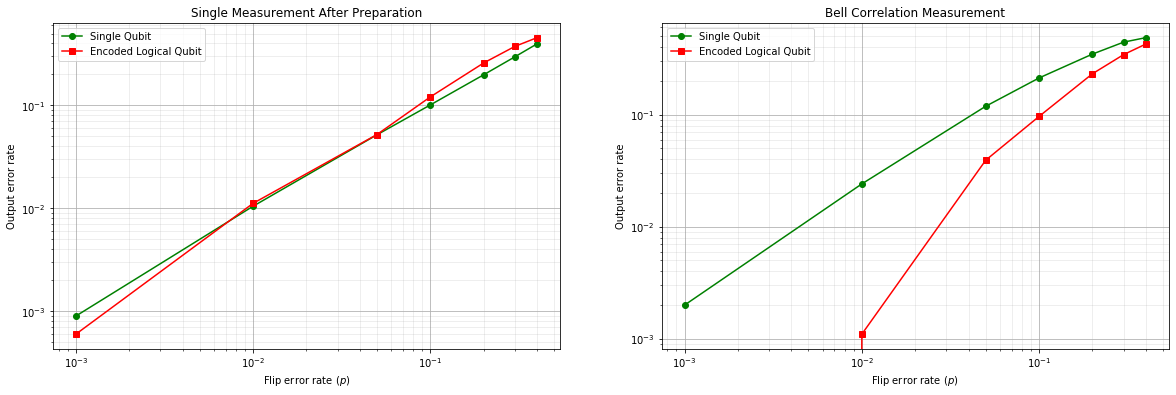

<Figure size 1440x432 with 0 Axes>

In [120]:
# Plot the data
plt.rcParams["figure.figsize"] = (20,6)

plt.subplot(1, 2, 1)
plt.loglog(errorRates, singleMeasurement, 'go-', label='Single Qubit')
plt.loglog(errorRates, singleMeasurementEncoded, 'rs-', label='Encoded Logical Qubit')
plt.legend()
plt.title("Single Measurement After Preparation")
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("Flip error rate ($p$)")
plt.ylabel("Output error rate")
plt.subplot(1, 2, 2)
plt.loglog(errorRates, bellTest, 'go-', label='Single Qubit')
plt.loglog(errorRates, bellTestEncoded, 'rs-', label='Encoded Logical Qubit')
plt.legend()
plt.grid()
plt.title("Bell Correlation Measurement")
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("Flip error rate ($p$)")
plt.ylabel("Output error rate")
plt.show()
plt.tight_layout()

Depending on the specific test cases (and the way we schedule the error correct cycle), our encoded logical qubit gives us good or bad results as compared to using raw qubits (the y-axis is the overall output error rate, lower is better.)

In general, the higher the underlying error rate is, the worse our code performs (i.e. closing the gap or even worse than using raw qubits.)

We will not dive into the theory or mathematical derivation trying to explain this behavior.
Instead, since we have high-level quantum programming languages, such as Q#, we can simulate this by going even further than single-level encoding, i.e. concatenate code.

## Concatenate Code

The qubits are encoded repeatedly one level to the next, i.e. encoded logical qubits act as elemental qubits at the higher level:
$$|0_L\rangle + |1_L\rangle = |0_{L1}0_{L1}0_{L1}\rangle + |1_{L1}1_{L1}1_{L1}\rangle$$
$$|0_{L1}\rangle + |1_{L1}\rangle = |0_{L2}0_{L2}0_{L2}\rangle + |1_{L2}1_{L2}1_{L2}\rangle$$
$$....$$

<img src="ConcatenateCode.png" style="width: 400px;">

Let's encode our three-qubit encoded qubits in the previous example into a 3-3-3 concatenated bit-flip code and try out the Bell test case.

In [130]:
# Concatenate bit-flip code Bell test implementation:
ConcatenateBitFlipCodeBellFaultyMeasurements = qsharp.compile("""
    operation EncodeIntoBitFlipConcatenateCode(data: Qubit, auxiliaryQubits: Qubit[]) : Unit {
        let register1 = [data] + auxiliaryQubits[0..1];
        let register2 =  auxiliaryQubits[2..4];
        let register3 =  auxiliaryQubits[5..7];
        let groupAuxiliaryQubits = [register2[0]] + [register3[0]];
                
        // Next, we encode our test state.
        // Encode from data qubit to the *master* qubit of each group
        EncodeIntoBitFlipCode(data, groupAuxiliaryQubits);
        // Encode each group
        EncodeIntoBitFlipCode(register2[0], register2[1..2]);
        EncodeIntoBitFlipCode(register3[0], register3[1..2]);
    }

    operation MeasureConcatenateCode(qubitRegister: Qubit[]) : Result {
        let register1 = qubitRegister[0..2];
        let register2 =  qubitRegister[3..5];
        let register3 =  qubitRegister[6..8];
                
        // Check if we are in zero state:
        let meas0 = MeasureLogicalQubit(register1);
        let meas1 = MeasureLogicalQubit(register2);
        if (meas0 == meas1)
        {
            return meas0;
        }
        else
        {
            // Last *encoded* qubit is the tie-breaker, we believe whatever it said :)
            return MeasureLogicalQubit(register3);
        }
    }
    
    operation LogicalX (reg : Qubit[]): Unit {
        X(reg[0]);
        X(reg[1]);
        X(reg[2]);
    }    

    operation RunErrorCorrectionCycleConcatenate (logicalQubit : Qubit[]) : Unit {
        let register1 = logicalQubit[0..2];
        let register2 =  logicalQubit[3..5];
        let register3 =  logicalQubit[6..8];
        // Error correction for each group (3-qubit code)
        RunErrorCorrectionCycle(register1);
        RunErrorCorrectionCycle(register2);
        RunErrorCorrectionCycle(register3);

        // Group to group parity
        using (ancilla = Qubit[3]) {
            LogicalCNOT(register1, ancilla);
            LogicalCNOT(register2, ancilla);
            let parity1 = MeasureLogicalQubit(ancilla);
            ResetAll(ancilla);
            
            LogicalCNOT(register2, ancilla);
            LogicalCNOT(register3, ancilla);
            let parity2 = MeasureLogicalQubit(ancilla);
            ResetAll(ancilla);
            
            // Correct error
            if (parity1 == One and parity2 == Zero) {
                LogicalX(register1);
            }
            elif (parity1 == One and parity2 == One) {
                LogicalX(register2);
            }
            elif (parity1 == Zero and parity2 == One) {
                LogicalX(register3);
            }
        }
    }
    
    operation LogicalCNOTConcetenate (reg1 : Qubit[], reg2: Qubit[]) : Unit {
        let register11 = reg1[0..2];
        let register12 =  reg1[3..5];
        let register13 =  reg1[6..8];

        let register21 = reg2[0..2];
        let register22 =  reg2[3..5];
        let register23 =  reg2[6..8];
        
        LogicalCNOT(register11, register21);
        LogicalCNOT(register12, register22);
        LogicalCNOT(register13, register23);
    }

    operation DoBellFaultyMeasurementsBitFlipConcatenateCode (nbRuns: Int) : Int {
        let nRuns = nbRuns;
        mutable nCorrect = 0;
        for (i in 1 .. nRuns) {
            using ((data1, auxiliaryQubits1, data2, auxiliaryQubits2) = (Qubit(), Qubit[8], Qubit(), Qubit[8])) {
                H(data1);
                
                EncodeIntoBitFlipConcatenateCode(data1, auxiliaryQubits1);
                EncodeIntoBitFlipConcatenateCode(data2, auxiliaryQubits2);
                
                let register1 = [data1] + auxiliaryQubits1;
                let register2 = [data2] + auxiliaryQubits2;

                LogicalCNOTConcetenate(register1, register2);
                
                RunErrorCorrectionCycleConcatenate(register1);
                RunErrorCorrectionCycleConcatenate(register2);

                // Do measurements
                if (MeasureConcatenateCode(register1) == MeasureConcatenateCode(register1)) {
                    set nCorrect += 1;
                }
                
                ResetAll(register1);
                ResetAll(register2);
            }
        }
        Message($"FlipCodeConcatenated(3x3): {nCorrect} runs out of {nRuns} produced the correct results.");
        return nCorrect;
   }
""")
# Dry run
# ConcatenateBitFlipCodeBellFaultyMeasurements[0].simulate(nbRuns=1)

In [117]:
%matplotlib inline
import numpy as np
errorRates = [0.05, 0.1, 0.2, 0.3, 0.4]

nbRuns = 1000
singleLevelCode = np.zeros(len(errorRates));
concatenateCode = np.zeros(len(errorRates));

testCase = "Bell"
for i in range(len(errorRates)):
    cmd = getExeCmd(errorRates[i], nbRuns, "Concatenate", testCase)
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    process.wait()
    result = int(process.stdout.read().split(b"Result = ", 1)[-1])
    concatenateCode[i] = 1.0 - result/nbRuns
    cmd = getExeCmd(errorRates[i], nbRuns, "Encoded", testCase)
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    process.wait()
    result = int(process.stdout.read().split(b"Result = ", 1)[-1])
    singleLevelCode[i] = 1.0 - result/nbRuns

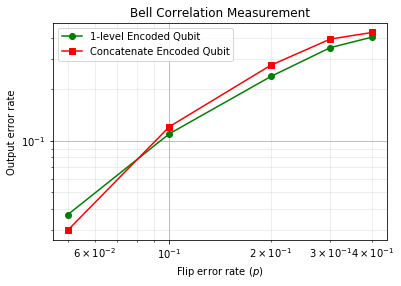

<Figure size 432x288 with 0 Axes>

In [118]:
plt.loglog(errorRates, singleLevelCode, 'go-', label='1-level Encoded Qubit')
plt.loglog(errorRates, concatenateCode, 'rs-', label='Concatenate Encoded Qubit')
plt.legend()
plt.title("Bell Correlation Measurement")
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("Flip error rate ($p$)")
plt.ylabel("Output error rate")
plt.show()
plt.tight_layout()

As we can see, there is a crossover point where the concatenated code performs worse than single-level encoding scheme. Although this is a simplistic toy model (3-qubit code is *not* a quantum error correction code), this behaviour is universal for all quantum error correction codes. The x-axis value of that crossover point is so-called **error threshold** and it's considered one of the most important figure-of-merits of a quantum error correction coding scheme.
This threshold determines when (how soon) in terms of qubit hardware error rates a code can scale up, i.e. arbitrary low output logical error rate can be achieved with the right amount of error correction.

Theoretical studies have so far indicated that topological quantum error correction codes, such as the *surface code*, are the best-performing codes in terms of error threshold. The error threshold of surface code (about 1%) is 100 times higher than that of other codes. 

In the followings, we'll implement, in Q#, a generic surface code qubit array which can be configured to model arbitrary surface code lattice. Thanks to its Host (C#) and Device (Q#) code segmentation, the surface code qubit array in Q# can be controlled (stabilizer grouping, error decoding, and qubit operations) by a classical controller implemented in C#.

# Surface Code

A surface code is a 2D qubit array that has its *data* and *syndrome* qubits interleaved as depicted below.

<img src="SurfaceCode.png" style="width: 600px;">

For details, please refer to Fowler et. al. (2012)

Thanks to its uniform layout, a surface code lattice/array can be implemented in Q# as follows.

In [131]:
SurfaceCodeRun = qsharp.compile("""
    // This is a simple example demonstrating surface code operation.
    // The example is constructed as a closely-coupled quantum device - classical host pair,
    // in which high-level classical logic (syndrome measurements, including opening/closing holes, applying gates to qubits)
    // is implemented by the host (as C#). The Q# operation hence becomes an infinite loop of error correction cycles (and occasionally applying gates).
    // We use the following convention for Pauli operators (as Int64): X(1), Y(2), Z(3)
    // For stablizer group: the data array (from host/controller) is [Pauli as Int, list of qubit indices]
    // For additional operators to apply at the end of a cycle has the format: [Pauli type, Index, Pauli type, Index, ...] 
    // Note: for the sake of simulation, we only have a *single* syndrome qubit, i.e. syndrome measurements are implemented sequentially.
    // This is obviously not the way surface code will be run, however, if time-scale is irrelevant (like in the simulation environment here),
    // it doesn't matter.
    operation RunSurfaceCodeErrorCorrectionCycle(nbQubits: Int, stabilizerGroupGen: (Unit -> Int[]), reportStabilizerResult: (Int -> Unit), applyOpGetFn: (Unit -> Int[])) : Unit {
        using ((dataQubits, ancilla) = (Qubit[nbQubits], Qubit())) {
            mutable hasStabilizerToMeasure = 1;
            repeat {
                let nextStabilizerGroupToMeasure = stabilizerGroupGen();
                if (Length(nextStabilizerGroupToMeasure) == 0) {
                    set hasStabilizerToMeasure = 0;
                }
                else {
                    if (nextStabilizerGroupToMeasure[0] == 3) {
                        // Pauli Z
                        Reset(ancilla);
                        for (index in 1 .. Length(nextStabilizerGroupToMeasure) - 1) {
                            CNOT(dataQubits[nextStabilizerGroupToMeasure[index]], ancilla);
                        }
                        let syndromeResult = M(ancilla);
                        Reset(ancilla);
                        if (syndromeResult == One) {
                            reportStabilizerResult(1); 
                        }
                        else {
                            reportStabilizerResult(0); 
                        }
                    }
                    elif (nextStabilizerGroupToMeasure[0] == 1){
                        Reset(ancilla);
                        H(ancilla);
                        for (index in 1 .. Length(nextStabilizerGroupToMeasure) - 1) {
                            CNOT(ancilla, dataQubits[nextStabilizerGroupToMeasure[index]]);
                            //Message($"CNOT(anc, q{nextStabilizerGroupToMeasure[index]})");
                        }
                        H(ancilla);
                        let syndromeResult = M(ancilla);
                        Reset(ancilla);
                        if (syndromeResult == One) {
                            reportStabilizerResult(1); 
                        }
                        else {
                            reportStabilizerResult(0); 
                        }
                    }
                    else {
                        set hasStabilizerToMeasure = 0;
                    }
                    
                    let qubitToApplyError = applyOpGetFn();

                    for (index in 0..2..Length(qubitToApplyError) - 1) {
                        let opCode = qubitToApplyError[index];
                        let qIdx = qubitToApplyError[index + 1];
                        if (opCode == 1) {
                            Message($"Apply X at q{qIdx}.");
                            X(dataQubits[qIdx]);
                        }
                        elif (opCode == 2) {
                            Message($"Apply Y at q{qIdx}.");
                            Y(dataQubits[qIdx]);
                        }
                        else {
                            Message($"Apply Z at q{qIdx}.");
                            Z(dataQubits[qIdx]);
                        }
                    }
                }
                
            }
            until (hasStabilizerToMeasure == 0);
            Message($"Finish! Reset all qubits.");
            ResetAll(dataQubits);
        }
    }
""")

Some notes about the above surface code implementation:

- The Q# code itself doesn't know anything about the surface code layout. Instead, it will invoke a controller hook which will then give it the list of qubits for a syndrome group ($X$ or $Z$)

- It will then report back the syndrome measurement results to the controller.

- The controller can give it a list of extra quantum gates to perform on data qubits.

This hybrid host-device implementation not only makes the code flexible but also provides a mechanism to implement arbitrary classical processing and optimization on top of the fixed Q# quantum code.

The controller code is implemeted in `SurfaceCodeDataStructure.cs` source file.

## Hand-on

Now, let's try a distance-3 surface code (13 data qubits).
In this test, we'll run the surface code for 50 cycles. Each cycle consists of measuring all the $X$ and $Z$ syndromes.
We purposely introduce some random $X$, $Y$, or $Z$ errors at random data qubits. The surface code will detect syndrome changes between cycles and print out the data for analysis. We can thus correlate between the error that we introduced and the syndrome changes. 

In [137]:
runCmd = os.getcwd() + '/SurfaceCode/bin/Debug/netcoreapp3.1/SurfaceCode'
process = subprocess.Popen(runCmd, shell=True, stdout=subprocess.PIPE)
process.wait()
for line in process.stdout.read().strip().decode().splitlines():
    print(line)
# Note: it's possible that we don't have any syndrome changes detected. Just try again.

Number of required qubits = 13
Apply Y at q3.
Parity changes detected:
======= BEFORE ========
Q00--(+)--Q01--(+)--Q02
 |    |    |    |    | 
(+)--Q03--(+)--Q04--(+)
 |    |    |    |    | 
Q05--(-)--Q06--(-)--Q07
 |    |    |    |    | 
(+)--Q08--(+)--Q09--(+)
 |    |    |    |    | 
Q10--(-)--Q11--(-)--Q12

======= AFTER ========
Q00--(+)--Q01--(+)--Q02
 |    |    |    |    | 
(-)--Q03--(-)--Q04--(+)
 |    |    |    |    | 
Q05--(+)--Q06--(-)--Q07
 |    |    |    |    | 
(+)--Q08--(+)--Q09--(+)
 |    |    |    |    | 
Q10--(-)--Q11--(-)--Q12

Parity changes detected:
======= BEFORE ========
Q00--(+)--Q01--(+)--Q02
 |    |    |    |    | 
(-)--Q03--(-)--Q04--(+)
 |    |    |    |    | 
Q05--(+)--Q06--(-)--Q07
 |    |    |    |    | 
(+)--Q08--(+)--Q09--(+)
 |    |    |    |    | 
Q10--(-)--Q11--(-)--Q12

======= AFTER ========
Q00--(-)--Q01--(+)--Q02
 |    |    |    |    | 
(-)--Q03--(-)--Q04--(+)
 |    |    |    |    | 
Q05--(+)--Q06--(-)--Q07
 |    |    |    |    | 
(+)--Q08--(+)--

Trying the above cell for a couple of times, we'll have an idea of how to localize the error from the syndromes changes. In practice, for big surface code arrays, this is a challenging problem. Technically, the + or - syndrome data points from the above example can be stacked on each other layer-by-layer ordered by time (syndrome cycles) to form a 3D graph from which one can guess the most probable errors which produced such syndrome transitions.

It's worth noting that we use a sequential syndrome measurement technique in the above example to minimize the number of qubits required for the simulation. Hence, a random error can occur *between* syndrome groups and thus be reported as two consecutive cycle-to-cycle changes. In practice, even with dedicated syndrome qubits and parallel syndrome measurements, this can still occur and it's the task of the error decoder to decode the most probable error.

### Extras:
With little efforts, we can try these for better understandings:
- Use the `faulty` simulator to see the syndromes are changed w.r.t. measurement errors.

- Use the `Enable` option of the syndrome qubit data-structure to create holes/defects (i.e. logical qubits)

# Conclusions

In this tutorial, we have explored the concept of error threshold by customizing the Q# simulator to embed our error model into the simulation. The result here is arbitrary since the bit-flip code is not a real quantum error code, the model and test set-up are kept simple for the sake of discussion, however, it has hopefully provided a concrete step-by-step example for you to build on.

We have also seen how the topological surface code works by simulating their syndrome measurement cycles under random error conditions. The hybrid classical-quantum implementation of this example demonstrated the extensibility and flexibility of the Q# programming model.

In [6]:
# Version info
qsharp.component_versions()

{'iqsharp': LooseVersion ('0.10.1912.501'),
 'Jupyter Core': LooseVersion ('1.2.20112.0'),
 '.NET Runtime': LooseVersion ('.NETCoreApp,Version=v3.0'),
 'qsharp': LooseVersion ('0.0.0.1')}